In [1]:
import numpy as np
import pandas as pd
from scipy.stats import levy_stable, norm

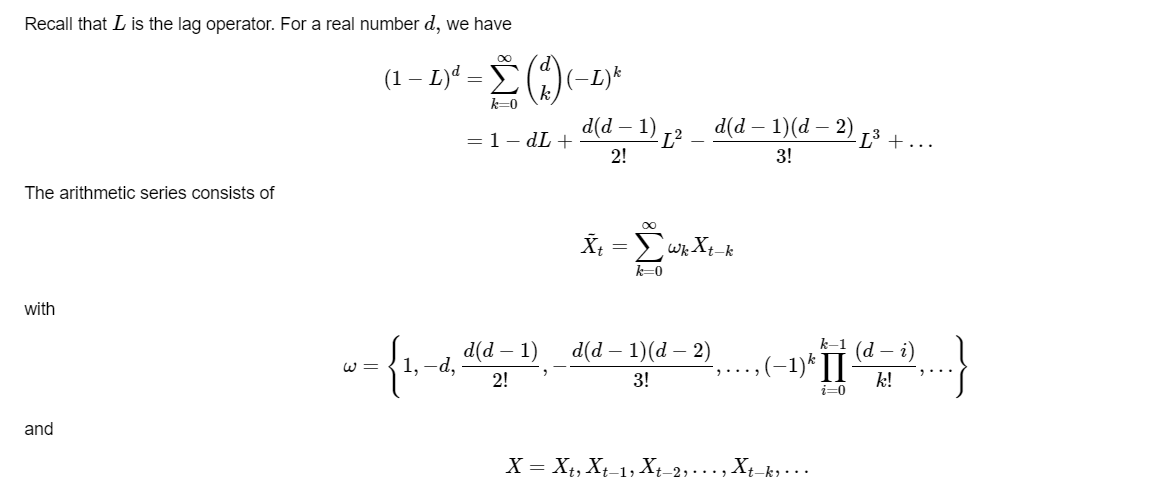

In [2]:
def get_weights(d, length, threshold=1e-5):
    """
    Computes the weights for the fractionally differentiated features up to a given threshold
    requirement for fixed-window fractional differencing.
    """
    w, k, w_curr = [1.], 1, 1
    
    while(k < length):
        w_curr = (-w[-1]/k*(d-k+1))
        
        if(abs(w_curr) <= threshold):    
            break
            
        w.append(w_curr)
        k += 1
        
    #reshape from a single row to a single column so they can be applied to time-series values easier
    w = np.array(w[::-1]).reshape(-1,1)
    
    return w

In [3]:
def fracdiff_FFD(series, d, threshold = 1e-5):
    """Computes fractionally differentiated series using fixed-width window"""
    weights = get_weights(d, len(series), threshold)
    width = len(weights) - 1
    df = {}
    
    for name in series.columns:
        #forward fill through unavailable prices and create a temporary series to hold values
        curr_series = series[[name]].fillna(method='ffill').dropna()
        df_temp = pd.Series(dtype='float64')
        
        #loop through all values that fall into range to be fractionally differentiated
        for iloc1 in range(width, curr_series.shape[0]):
            #set values for first and last time-series point to be used in current pass of fractional
                #difference
            
            loc0 = curr_series.index[iloc1-width]
            loc1 = curr_series.index[iloc1]
            
            #make sure current value is valid
            if not np.isfinite(curr_series.loc[loc1,name]):
                continue
            
            #dot product of weights with values from first and last indices
            df_temp.at[loc1] = np.dot(weights.T, curr_series.loc[loc0:loc1])[0,0]
            
        df[name] = df_temp.copy(deep=True)
    df = pd.concat(df, axis=1)
            
    return df

In [4]:
def ma_model(params, n_points, noise_std = 1, noise_alpha = 2):
    """
    Generate discrete series using MA process
    Coefficients used by the MA process:
        x[t] = params[1]*epsi[t-1] + params[2]*epsi[t-2] + ... + epsi[t]
    """
    ma_order = len(params)
    
    if noise_alpha == 2:
        noise = norm.rvs(scale=noise_std, size=(n_points + ma_order))
    else:
        noise = levy_stable.rvs(
            noise_alpha, 0, scale=noise_std, size=(n_points + ma_order)
        )

    if ma_order == 0:
        return noise
    
    ma_coeffs = np.append([1], params)
    ma_series = np.zeros(n_points)
    
    for idx in range(ma_order, n_points + ma_order):
        take_idx = np.arange(idx, idx - ma_order - 1, -1).astype(int)
        ma_series[idx - ma_order] = np.dot(ma_coeffs, noise[take_idx])
        
    return ma_series[ma_order:]

In [5]:
def arma_model(params, noise):
    """
    Generate discrete series using ARMA process
    Coefficients used by the AR process:
        x[t] = params[1]*x[t-1] + params[2]*x[t-2] + ... + epsi[t]
    """
    ar_order = len(params)
    
    if ar_order == 0:
        return noise
    
    n_points = len(noise)
    arma_series = np.zeros(n_points + ar_order)
    
    for idx in range(ar_order, len(arma_series)):
        take_idx = np.arange(idx - 1, idx - ar_order - 1, -1).astype(int)
        arma_series[idx] = np.dot(params, arma_series[take_idx]) + noise.iloc[idx - ar_order]
    
    return arma_series[ar_order:]

In [6]:
def arfima_sim(
    ar_params,
    d,
    ma_params,
    n_points,
    noise_std = 1,
    noise_alpha = 2,
    warmup = 0):
    """Generate discrete series using ARFIMA process"""
    ma_list = ma_model(
        ma_params, n_points + warmup, noise_std=noise_std, noise_alpha=noise_alpha
    )
    ma_df = pd.DataFrame(ma_list, columns=["MA Series"])
    frac_ma = fracdiff_FFD(ma_df, d)
    arfima_series = arma_model(ar_params, frac_ma)
    return arfima_series[-n_points:]